# Delays and offsets

To validate our results we look at different delays and offsets. The goal here is to analyse the effect of different prior delays and different game offsets.

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [2]:
%load_ext autoreload
%autoreload 2

def load_function(country, offset=0, mwd="1.0", interval_cps="10.0", f_fem="0.33", f_robust="1.0", len="normal"):
        folder="covid_uefa_traces14_robustness"
        fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/{folder}/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data={offset}"+
            f"-prior_delay=-1"+
            f"-median_width_delay={mwd}"+
            f"-interval_cps={interval_cps}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if not f_robust == "1.0":
            fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
                f"-beta=False"+
                f"-country={country}"+
                f"-offset_data={offset}"+
                f"-prior_delay=-1"+
                f"-median_width_delay={mwd}"+
                f"-interval_cps={interval_cps}"+
                f"-f_fem={f_fem}"+
                f"-len=normal"+
                f"-abs_sine=False"+
                f"-t={tune}"+
                f"-d={draws}"+
                f"-max_treedepth={max_treedepth}.pkl")
        model = None
        
        tune, draws, max_treedepth = (2000, 4000, 12)
        folder="covid_uefa_traces14_robustness"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
            
        tune, draws, max_treedepth = (1000, 2000, 12)
        folder="covid_uefa_traces15"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        
        if model is None: 
            print(fstr(tune, draws, max_treedepth, folder), " not found")
            return None, None
        
        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)
        return model, trace

In [3]:
# Offset
#offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']
offsets = [-40, -35, -30, 0, 30, 35, 40]

models = {}
traces, traces_without_soccer, traces_primary_soccer  = {} , {} , {}
dls = {}
for country in tqdm(countries):
    models_temp = []
    traces_temp = []
    traces_without_soccer_temp = []
    traces_primary_soccer_temp = []
    dls_temp = []
    for offset in offsets:
        print(f"{country} {offset}" )

        model,trace = load_function(country, offset= offset)
    
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_data=offset)
        models_temp.append(model)
        traces_temp.append(trace)
        
        
        dls_temp.append(dl)
    models[country] = models_temp
    
    traces[country] = traces_temp
    traces_without_soccer[country] = traces_without_soccer_temp
    traces_primary_soccer[country] = traces_primary_soccer_temp
    
    dls[country] = dls_temp

  0%|          | 0/12 [00:00<?, ?it/s]

England -40
Use 2000 sample runs for England with -40 offset
England -35
Use 2000 sample runs for England with -35 offset
England -30
Use 2000 sample runs for England with -30 offset
England 0
Use 4000 sample runs for England with 0 offset
England 30
Use 2000 sample runs for England with 30 offset
England 35
Use 2000 sample runs for England with 35 offset
England 40
Use 2000 sample runs for England with 40 offset
Czechia -40
Use 2000 sample runs for Czechia with -40 offset
Czechia -35
Use 2000 sample runs for Czechia with -35 offset
Czechia -30
Use 2000 sample runs for Czechia with -30 offset
Czechia 0
Use 4000 sample runs for Czechia with 0 offset
Czechia 30
Use 2000 sample runs for Czechia with 30 offset
Czechia 35
Use 2000 sample runs for Czechia with 35 offset
Czechia 40
Use 2000 sample runs for Czechia with 40 offset
Scotland -40
Use 2000 sample runs for Scotland with -40 offset
Scotland -35
Use 2000 sample runs for Scotland with -35 offset
Scotland -30
Use 2000 sample runs for Sc

In [4]:

    
# Compute interesting values as fractionv
primary_frac = []
for i, country in enumerate(countries):
    primary_frac_t = []
    
    for o, offset in enumerate(offsets):
        if models[country][o] is None:
            print(f"Country {country} with offset {offset} not found")
            o = 3
        traces[country][o].posterior = traces[country][o].posterior.isel(draw=np.arange(-2000,0), chain=np.arange(6)) # make all the same shape
        frac_pr = covid19_soccer.plot.other.calc_fraction_primary(model=models[country][o], trace=traces[country][o], dl=dls[country][o])
        print(frac_pr.shape, country)
        primary_frac_t.append(frac_pr*100)
    primary_frac.append(np.array(primary_frac_t))

(12000, 2) England
(12000, 2) England
(12000, 2) England
(12000, 2) England
(12000, 2) England
(12000, 2) England
(12000, 2) England
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Czechia
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Scotland
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Spain
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Italy
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Slovakia
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Germany
(12000, 2) Austria
(12000, 2) Austria
(12000, 2) Austria
(12000, 2) Austria
(12000,

In [20]:
def reduce_samples_and_transpose(curr_list):
    number_of_samples = 1000
    for i, array in enumerate(curr_list):
        array=array.T
        array = array[...,np.random.choice(array.shape[-1], number_of_samples, replace = False)]
        curr_list[i] = array
    return np.array(curr_list)

def calc_overall_effect(primary_frac):

    primary_frac = reduce_samples_and_transpose(primary_frac)
    
    n_countries = len(countries)
    with pm.Model() as model:
        overall_effect = pm.Normal("overall_effect", mu=0, sigma=10, shape=(2,))
        tau = pm.HalfCauchy("tau", beta=10, shape=(2,))

        deviation = pm.Normal("deviation", mu=0, sigma=1, shape=(n_countries, 2))
        country_effect = deviation*tau + overall_effect
        country_effect = pm.Deterministic("country_effect", country_effect)

        sigma_obs = pm.HalfCauchy("sigma", beta=10, shape=(n_countries, 2))

        pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=primary_frac)
    
    with model:
        trace = pm.sample(tune=1000, draws=1000, chains=4, target_accept=0.95,
                          return_inferencedata=True)

        post_pred = pm.sample_posterior_predictive(trace)

    az.concat(trace, az.from_pymc3(posterior_predictive=post_pred), inplace=True)
    return get_from_trace("overall_effect", trace)

overall_effects = []

for i_offset in tqdm(range(len(offsets))):
    primary_frac_of_single_offset = []
    for i_country, country in enumerate(countries):
        primary_frac_of_single_offset.append(primary_frac[i_country][i_offset])
    overall_effects.append(calc_overall_effect(primary_frac_of_single_offset))

  0%|          | 0/7 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 687 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 687 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 944 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 944 seconds.
The number of effective samples is smaller than 10% for some parameters.
WARNING  [pymc3] The number of effective samples is smaller than 10% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 911 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 911 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1768 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1768 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1428 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1428 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 798 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 798 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 966 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 966 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


# Create plot different offests

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1257: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1261: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


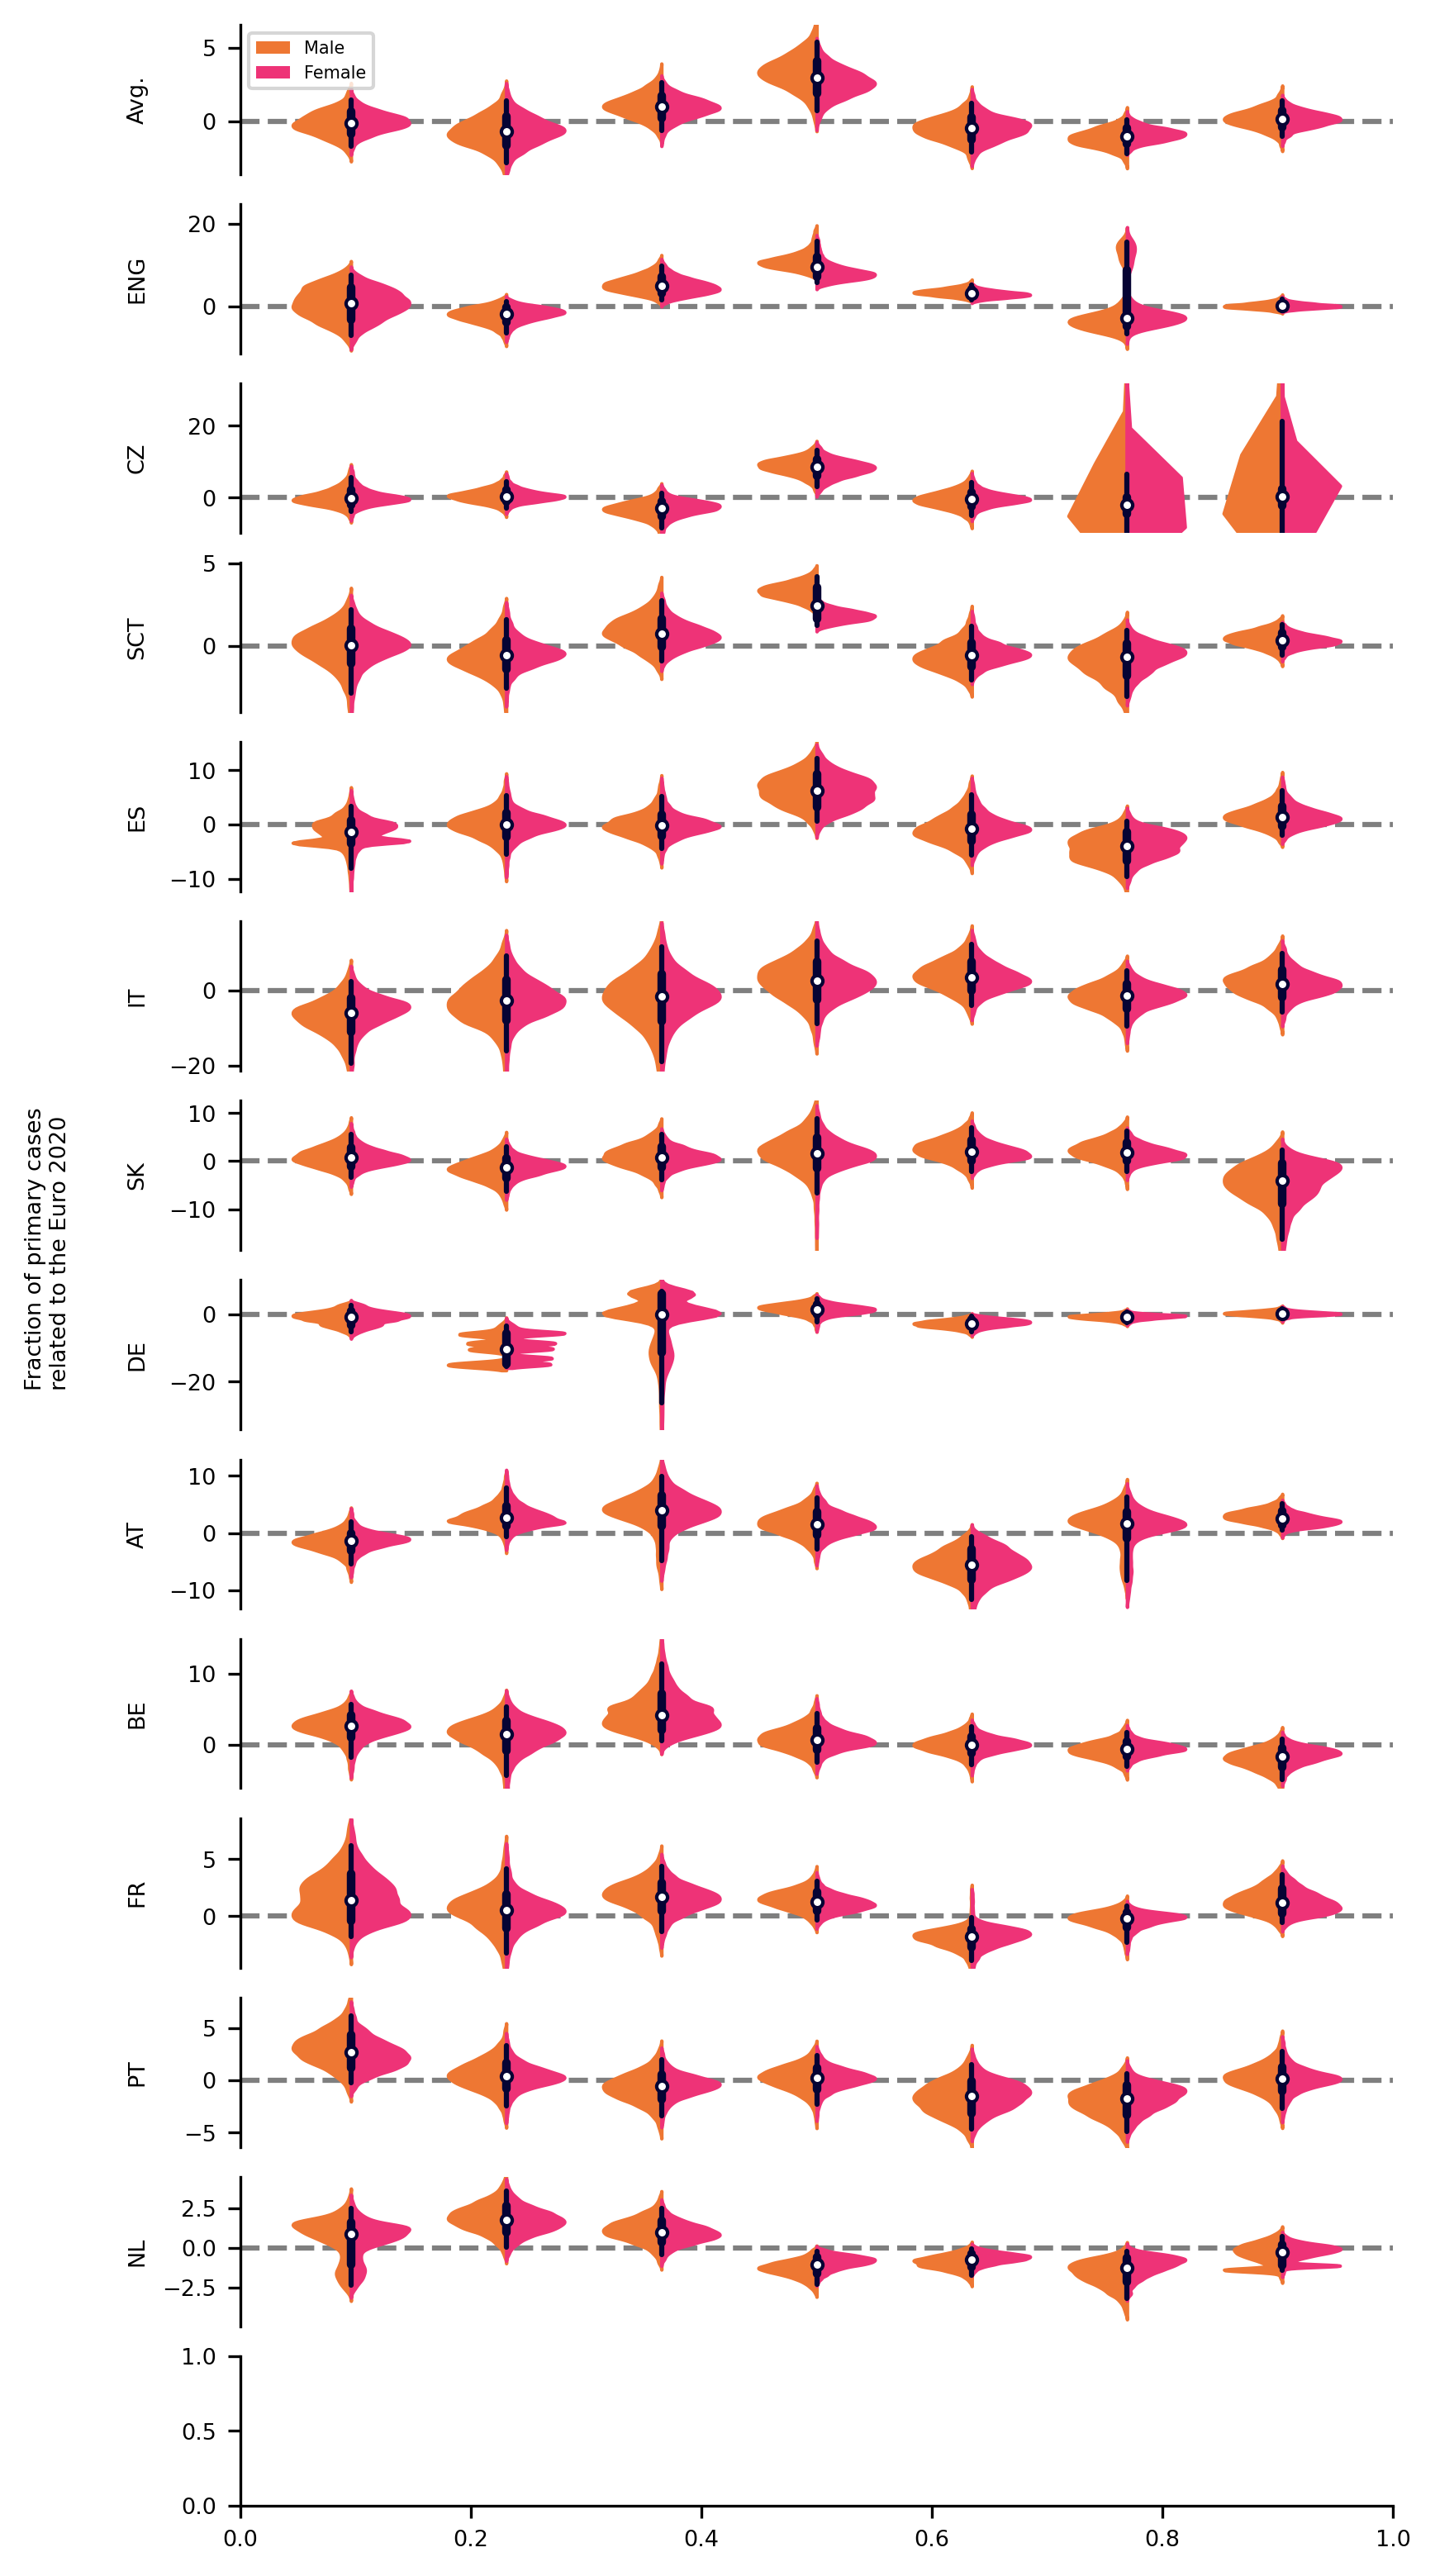

In [42]:
from covid19_soccer.plot.other import legend,hviolins

#primary_frac.insert(0, np.array(overall_effects))
#countries.insert(0, "Avg.")


def whisker_plot(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.spines["left"].set_visible(True)

    



plt.close("all")

fig,axes = plt.subplots(len(countries) + 1,1,figsize=(6,len(countries)*1))


for i, country in enumerate(countries):
    # Violins & whisker
    if country == "France" and False:
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T]]
        ci = np.array(ci).T
        hviolins(
            axes[i],
            [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T],
            offsets,
        )
        axes[i].set_ylim(-2,3.5)
    else:
        
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac[i]]
        ci = np.array(ci).T
        
        hviolins(
            axes[i],
            [array.T for array in primary_frac[i]],
            offsets,
        )
    
    whisker_plot(
        axes[i],
        [0,1,2,3,4,5,6],
        ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:],
    )


        
    # Markup
    
    mean = np.mean(ci[1])
    min_val = np.min(ci[1]+3*(ci[3] - ci[1]))
    max_val = np.max(ci[1]+1.5*(ci[2] - ci[1]))

    
    axes[i].set_ylim(min_val, max_val)
    if not country =="Avg.":
        axes[i].set_ylabel(dls[country][0].countries_iso2[0].replace("GB-",""))
    else:
        axes[i].set_ylabel("Avg.")
    axes[i].set_xticklabels([])
    axes[i].get_legend().remove()
    axes[i].set_xlabel(None)
    axes[i].axhline(0,ls="--",color="tab:gray",zorder=-5)
    
    axes[i].spines["bottom"].set_visible(False)
    if i == len(countries):
        axes[i].set_xticklabels(offsets)
        axes[i].spines["bottom"].set_visible(True)
        axes[i].set_xlabel("Match offset (days)")
    else:
        axes[i].xaxis.set_ticks_position('none')
    
    
legend(
    ax=axes[0],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="upper left",
)
fig.align_ylabels()
fig.supylabel("Fraction of primary cases\nrelated to the Euro 2020",x=-0.02)

fig.savefig(f"../figures/SI/delay_offset_overview.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/delay_offset_overview.png", **save_kwargs)
plt.show()


/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1257: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1261: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


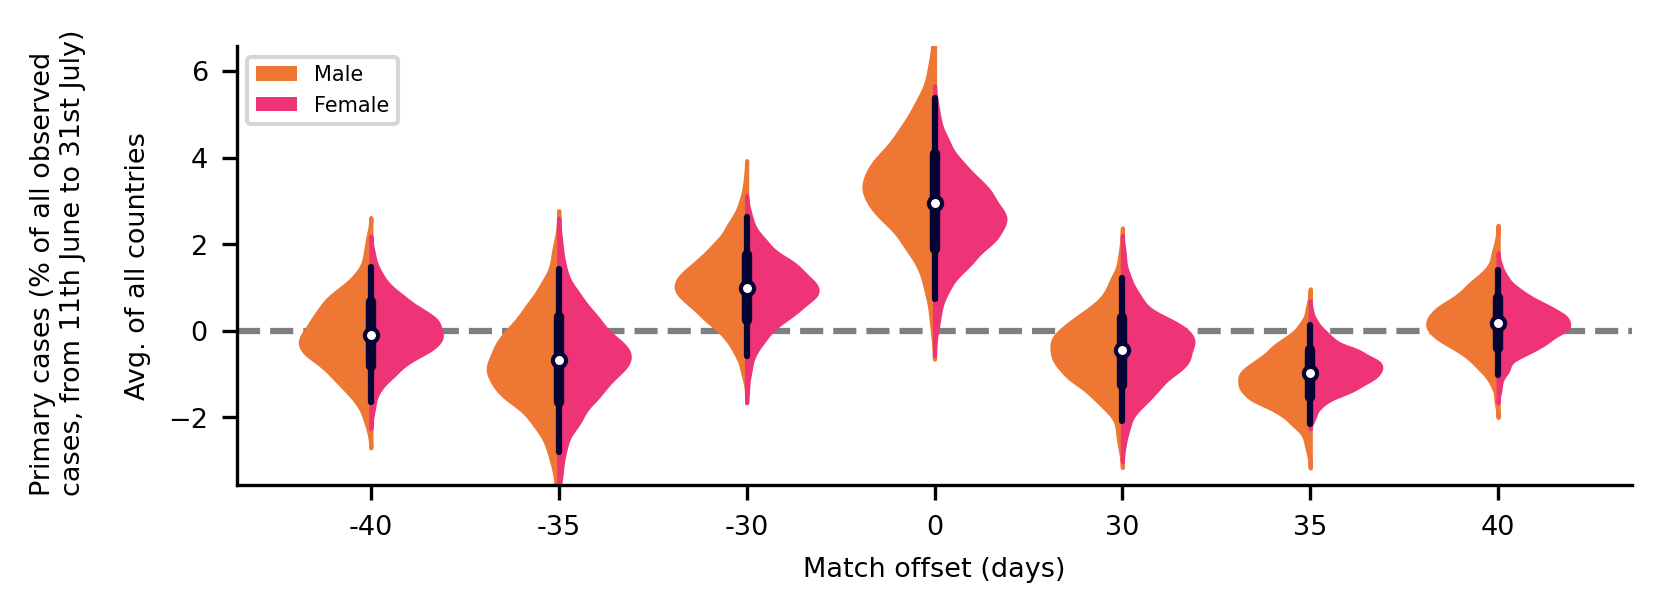

In [50]:
fig,ax = plt.subplots(1,1,figsize=(6,1.9))

axes = [ax]

for i, country in zip(range(1),countries):
    # Violins & whisker
    if country == "France" and False:
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T]]
        ci = np.array(ci).T
        hviolins(
            axes[i],
            [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T],
            offsets,
        )
        axes[i].set_ylim(-2,3.5)
    else:
        
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac[i]]
        ci = np.array(ci).T
        
        hviolins(
            axes[i],
            [array.T for array in primary_frac[i]],
            offsets,
        )
    
    whisker_plot(
        axes[i],
        [0,1,2,3,4,5,6],
        ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:],
    )


        
    # Markup
    
    mean = np.mean(ci[1])
    min_val = np.min(ci[1]+3*(ci[3] - ci[1]))
    max_val = np.max(ci[1]+1.5*(ci[2] - ci[1]))

    
    axes[i].set_ylim(min_val, max_val)
    if not country =="Avg.":
        axes[i].set_ylabel(dls[country][0].countries_iso2[0].replace("GB-",""))
    else:
        axes[i].set_ylabel("Avg. of all countries")
    axes[i].set_xticklabels([])
    axes[i].get_legend().remove()
    axes[i].set_xlabel(None)
    axes[i].axhline(0,ls="--",color="tab:gray",zorder=-5)
    
    axes[i].spines["bottom"].set_visible(False)
    if i == 0:
        axes[i].set_xticklabels(offsets)
        axes[i].spines["bottom"].set_visible(True)
        axes[i].set_xlabel("Match offset (days)")
    else:
        axes[i].xaxis.set_ticks_position('none')
    
    
legend(
    ax=axes[0],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="upper left",
)
fig.align_ylabels()
fig.supylabel("Primary cases (% of all observed\ncases, from 11th June to 31st July)",x=0.01)

fig.savefig(f"../figures/SI/delay_offset_avg.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/delay_offset_avg.png", **save_kwargs)
plt.show()

## Offsets against delay

A:
--
- x : offset $[-2,2]$
- y : Delay

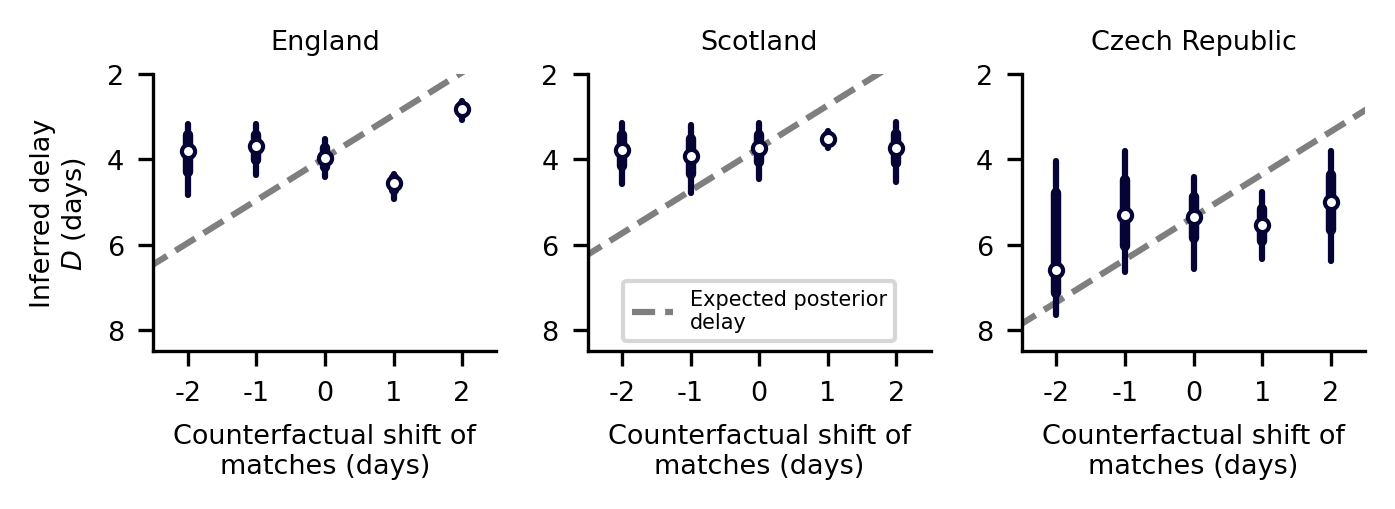

In [6]:
from covid19_soccer.plot.other import MulticolorPatch, MulticolorPatchHandler, Line2D, Rectangle, HandlerRect, rcParams
def whisker_plot(ax, x, y_median, y_lower_95, y_upper_95, y_lower_68, y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )



def offset_delay_plot(ax,traces,models,dls):
    delays = []
    cis = []
    
    # compute values
    for tr in traces:
        delay = get_from_trace("delay",tr)
        delays.append(delay)
        
        ci = np.percentile(delay, q=(50, 2.5, 97.5, 16, 84))
        cis.append(ci)
    cis = np.array(cis)
    
    
    """Plots
    """
    
    # Whiskers 
    for i,ci in enumerate(cis):
        whisker_plot(ax,i,*ci)
    
    # Line
    intercept = cis[2][0]
    slope = -1
    
    x = np.array([-1,6])
    ax.plot(x,(x-2)*slope+intercept,ls="--",color="tab:gray")
    

def plot_legend(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(Line2D(
                [0],
                [0],
                color="tab:gray",
                ls="--",
                lw=1.5,
                marker=None,
                ms=3.5
            ))
    labels.append("Expected posterior\ndelay") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax
    
fig, axes = plt.subplots(1,3,figsize=(4.75,1.8))


for i, c in enumerate(["England","Scotland","Czechia"]):
    ax = axes[i]
    offset_delay_plot(axes[i],traces[c],models[c],dls[c])

    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([-2,-1,0,1,2])
    ax.set_xlim([-0.5,4.5])
    if c == "Czechia":
        ax.set_title("Czech Republic")
    else:
        ax.set_title(c)
    ax.set_ylim(8.5,2)
    
    ax.set_xlabel("Counterfactual shift of\nmatches (days)")
    if i == 0:
        ax.set_ylabel("Inferred delay\n$D$ (days)")
    if i == 1:
        plot_legend(ax,"lower center")
        

fig.tight_layout()
fig.savefig(f"../figures/SI/delay_offset_eng_sct_cz.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/delay_offset_eng_sct_cz.png", **save_kwargs)
plt.show()